In [11]:
from pathlib import Path
import os
# Get the data directory 
DATA_DIR = Path(os.path.join(os.getcwd(), '..', 'data')).resolve() # (one level above the current working directory)
# Check if the data directory exists
print(f"{DATA_DIR}")

/Users/viggo/Documents/Programming/Consult/UNU/data


In [12]:
# Define bounding box for Mexico and Guatemala
bbox = {
    "lon_min": -120,
    "lon_max": -85,
    "lat_min": 13,
    "lat_max": 32
}

## Hazard - VPD

- Get the VPD 
- See https://github.com/zeliest/coffee_banana_cacao_climate_risk/blob/main/VPD_impact_calculation.ipynb

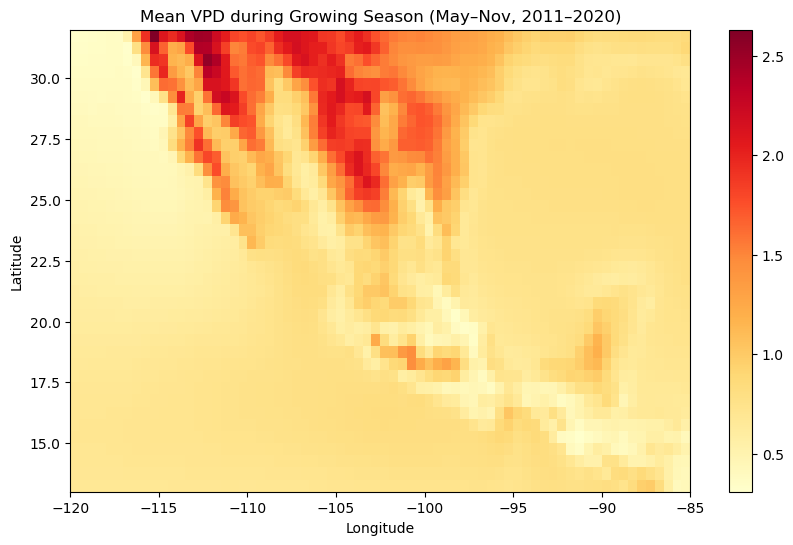

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
humidity_path = DATA_DIR / "20crv3-era5_obsclim_hurs_global_daily_2011_2020.nc"
temperature_path = DATA_DIR / "20crv3-era5_obsclim_tas_global_daily_2011_2020.nc"

ds_hurs = xr.open_dataset(humidity_path)
ds_tas = xr.open_dataset(temperature_path)

# Assume variable names are 'hurs' and 'tas'
hurs = ds_hurs['hurs']
tas = ds_tas['tas']

# 🔥 First spatial subset
tas = tas.sel(lat=slice(bbox["lat_max"], bbox["lat_min"]),
              lon=slice(bbox["lon_min"], bbox["lon_max"]))
hurs = hurs.sel(lat=slice(bbox["lat_max"], bbox["lat_min"]),
              lon=slice(bbox["lon_min"], bbox["lon_max"]))

# Convert temperature from Kelvin to Celsius
tas_celsius = tas - 273.15

# Select growing season months (May to November)
growing_season = tas_celsius['time.month'].isin([5, 6, 7, 8, 9, 10, 11])

tas_gs = tas_celsius.sel(time=growing_season)
hurs_gs = hurs.sel(time=growing_season)

# Calculate saturation vapour pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * tas_gs) / (tas_gs + 237.3))

# Calculate actual vapour pressure (ea) in kPa
ea = (hurs_gs / 100) * es

# Calculate VPD
vpd = es - ea

# Now groupby year and average VPD over growing season
vpd_yearly_mean = vpd.groupby('time.year').mean(dim='time')

# Final: average across all years (2011–2020)
vpd_growing_season_mean = vpd_yearly_mean.mean(dim='year')

# Plot
plt.figure(figsize=(10, 6))
vpd_growing_season_mean.plot(cmap="YlOrRd")
plt.title("Mean VPD during Growing Season (May–Nov, 2011–2020)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [14]:
vpd_yearly_mean

<xarray.DataArray (year: 10, lat: 38, lon: 70)> Size: 106kB
array([[[0.3045287 , 0.30522704, 0.30593413, ..., 0.98931307,
         0.98900956, 1.0359585 ],
        [0.32270756, 0.3228469 , 0.3182833 , ..., 0.9763817 ,
         1.0239382 , 1.0968012 ],
        [0.33665413, 0.33551767, 0.3292367 , ..., 0.84941614,
         0.87828404, 0.9500234 ],
        ...,
        [0.6758055 , 0.6826275 , 0.6900067 , ..., 0.5191487 ,
         0.449832  , 0.4473203 ],
        [0.6798222 , 0.68588144, 0.69170487, ..., 0.48176667,
         0.43506512, 0.40321207],
        [0.6839611 , 0.6898361 , 0.6942543 , ..., 0.46855727,
         0.3888857 , 0.41612804]],

       [[0.27877542, 0.29129884, 0.2983404 , ..., 0.8575194 ,
         0.85891664, 0.8954794 ],
        [0.29460463, 0.30622688, 0.31237945, ..., 0.81268525,
         0.848926  , 0.9330383 ],
        [0.3032911 , 0.31449226, 0.31854174, ..., 0.6998123 ,
         0.7483362 , 0.8212108 ],
...
        [0.70341724, 0.7019136 , 0.7014037 , ..., 0.7020551 ,
         0.5506985 , 0.51702625],
        [0.6843686 , 0.68606323, 0.68982506, ..., 0.6712339 ,
         0.5214988 , 0.47137377],
        [0.67329115, 0.67697275, 0.6818662 , ..., 0.68157554,
         0.4611283 , 0.46418676]],

       [[0.32963592, 0.34052113, 0.35013944, ..., 0.8132094 ,
         0.8444101 , 0.89217913],
        [0.35305837, 0.35806185, 0.35763156, ..., 0.7524529 ,
         0.80853844, 0.8920812 ],
        [0.3685893 , 0.36615065, 0.36121586, ..., 0.6784473 ,
         0.7163507 , 0.7785987 ],
        ...,
        [0.6934901 , 0.6871632 , 0.68291247, ..., 0.5251499 ,
         0.45543018, 0.45123932],
        [0.6916808 , 0.68651414, 0.6821086 , ..., 0.51020086,
         0.4426223 , 0.41407105],
        [0.68712664, 0.6864707 , 0.68338734, ..., 0.506887  ,
         0.39102358, 0.4134626 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 560B -119.8 -119.2 -118.8 ... -86.25 -85.75 -85.25
  * lat      (lat) float64 304B 31.75 31.25 30.75 30.25 ... 14.25 13.75 13.25
  * year     (year) int64 80B 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020

In [15]:
vpd_dataset = vpd_yearly_mean.to_dataset(name='vpd')


In [16]:
vpd_dataset = vpd_dataset.rename({"year":"time","lat":"latitude","lon":"longitude"})

In [17]:
from climada.hazard import Hazard
vpd = Hazard.from_xarray_raster(vpd_dataset, intensity='vpd', hazard_type='VPD', intensity_unit='kPA')

2025-04-29 15:13:39,105 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


In [18]:
#years = vpd_dataset.year.values
#n_events = len(years)

#vpd.frequency = np.ones(len(vpd.frequency)) *

<GeoAxes: title={'center': 'VPD max intensity at each point'}>

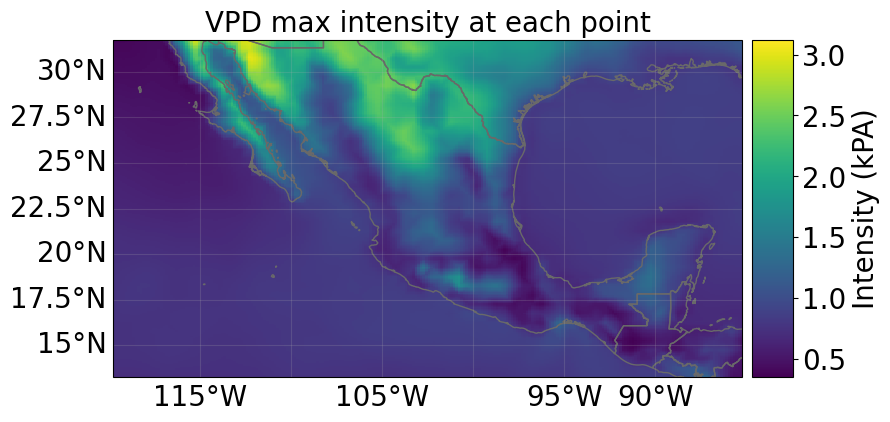

In [19]:
vpd.plot_intensity(0)

<GeoAxes: title={'center': '1-largest Event. ID 1:'}>

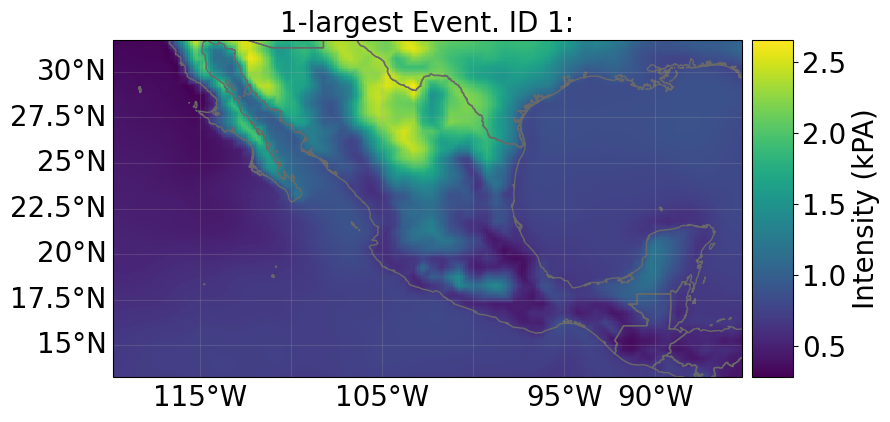

In [20]:
# worst event
vpd.plot_intensity(-1)

In [21]:
# Function making hazard of isimip temperature and humidity data 


## Exposure – Coffe Yield

- Each raster value corresponds to average yield (t/ha) in a specific pixel during that year — not a time series.
- Data from : https://mapspam.info

✅ Summary for Arabica Yield
- CSV column: coff_TA (or coff_TI, coff_TR)
- GeoTIFF: spam2020V1r0_global_Y_coff_TA.tif
- Unit: Yield in metric tonnes per hectare (t/ha)
- Year: 2020
- Resolution: Pixel-level (grid, global coverage)

📊 Variables

Files or columns with:
- _Y_ represent Yield
- _A_ = Physical area
- _H_ = Harvested area
- _P_ = Production

Production (tons) = Yield (tons/ha) × Area Harvested (ha)

In [22]:
from climada.entity import Exposures

file = DATA_DIR / "spam2020V1r0_global_yield/spam2020_v1r0_global_Y_COFF_A.tif"
exp = Exposures.from_raster(file)

In [23]:
exp.gdf['impf_VPD'] = 1

In [24]:
# Select only exposures inside the bounding box
exp_central_america = exp.gdf[
    (exp.gdf.geometry.x >= bbox["lon_min"]) &
    (exp.gdf.geometry.x <= bbox["lon_max"]) &
    (exp.gdf.geometry.y >= bbox["lat_min"]) &
    (exp.gdf.geometry.y <= bbox["lat_max"])
].copy()

In [25]:
Exposures?

Init signature:
Exposures(
    data=None,
    index=None,
    columns=None,
    dtype=None,
    copy=False,
    geometry=None,
    crs=None,
    meta=None,
    description=None,
    ref_year=None,
    value_unit=None,
    value=None,
    lat=None,
    lon=None,
)
Docstring:     
geopandas GeoDataFrame with metadata and columns (pd.Series) defined in
Attributes.

Attributes
----------
description : str
    metadata - description of content and origin of the data
ref_year : int
    metadata - reference year
value_unit : str
    metadata - unit of the exposures values
data : GeoDataFrame
    containing at least the columns 'geometry' and 'value' for locations and assets
    optionally more, a.o., 'region_id', 'category_id', columns for (hazard specific) assigned
    centroids and (hazard specific) impact funcitons.
Init docstring:
Parameters
----------
data : dict, iterable, DataFrame, GeoDataFrame, ndarray
    data of the initial DataFrame, see ``pandas.DataFrame()``.
    Used to initial

In [26]:
exp_central_america = Exposures(data=exp_central_america)

In [27]:
exp_central_america.gdf

,value,impf_VPD,geometry
3007440,0.0,1,POINT (-119.95833 31.95833)
3007441,0.0,1,POINT (-119.87500 31.95833)
3007442,0.0,1,POINT (-119.79167 31.95833)
3007443,0.0,1,POINT (-119.70833 31.95833)
3007444,0.0,1,POINT (-119.62500 31.95833)
...,...,...,...
3988495,0.0,1,POINT (-85.37500 13.04167)
3988496,0.0,1,POINT (-85.29167 13.04167)
3988497,0.0,1,POINT (-85.20833 13.04167)
3988498,0.0,1,POINT (-85.12500 13.04167)


## Vulnerability 

vulnerability taken from this figure: https://www.nature.com/articles/s43016-022-00614-8/figures/1

<Axes: title={'center': 'VPD 1: Arabica VPD effect'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>

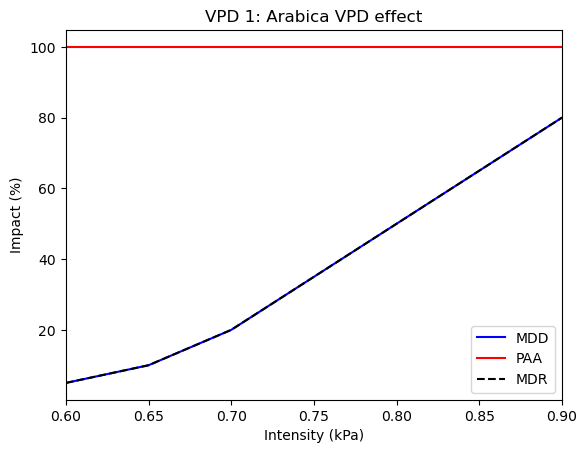

In [28]:
import numpy as np
import pandas as pd
from climada.entity import ImpactFunc

# Load your extracted VPD-effect table
vpd_data = pd.read_csv('vpd_effect_approximation.csv')
vpd_data = vpd_data[vpd_data.Effect_Central<0]
# Extract intensity (VPD) and effect (impact)
vpd_intensity = vpd_data['Mean_VPD_kPa'].values
effect = vpd_data['Effect_Central'].values

# CLIMADA needs MDD (mean damage degree), which must be between 0 and 1
# The "effect" is scaled roughly from -1 to 1 in the original paper figure
# We can map it to MDD: set 0 effect -> 0.5 MDD; -1 -> 1; 1 -> 0 (inverted risk)
mdd = -effect  # simple linear mapping

# Clip to valid range [0,1] just in case
mdd = np.clip(mdd, 0, 1)

# Assume full probability of asset affection (PAA)
paa = np.ones_like(mdd)

# Create the Impact Function
imp_fun_vpd = ImpactFunc(
    id=1,
    name="Arabica VPD effect",
    haz_type="VPD",  # you can define a custom hazard type
    intensity=vpd_intensity,
    mdd=mdd,
    paa=paa,
    intensity_unit="kPa"
)

# Check and plot
imp_fun_vpd.check()
imp_fun_vpd.plot()

In [29]:
# Store the impact function in impact function set
from climada.entity import ImpactFuncSet
# Create an empty ImpactFuncSet
impf_set = ImpactFuncSet()

# add the 2 impact functions into ImpactFuncSet
imp_fun_set = ImpactFuncSet([imp_fun_vpd])

## Impact Calculation

2025-04-29 15:13:53,072 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

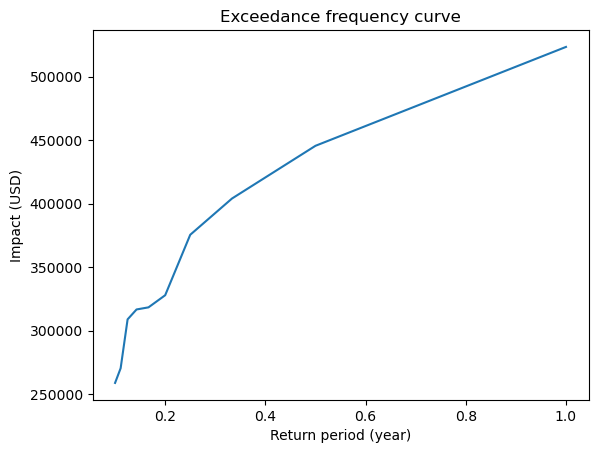

In [30]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp_central_america, imp_fun_set, vpd).impact(
    save_mat=False
)  # Do not save the results geographically resolved (only aggregate values)

imp.calc_freq_curve().plot()

## Adaptation Measure - Canopy Cover

### Step 1 - Get current canopy cover ()

- https://www.globalforestwatch.org/
- https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html

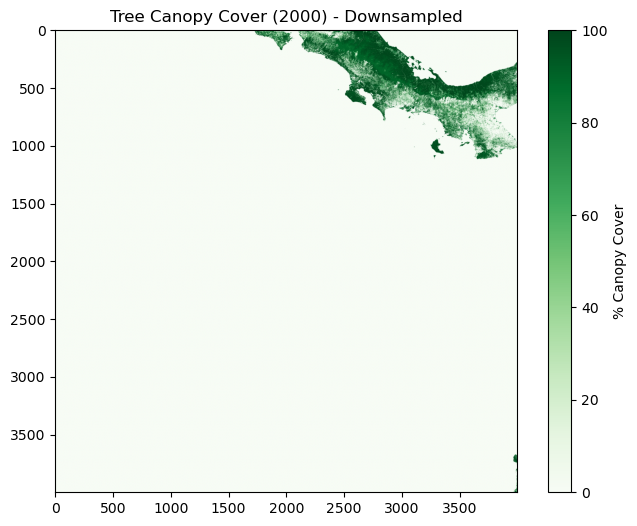

In [31]:
import rasterio
import matplotlib.pyplot as plt

# Path to your downloaded tree cover file
path_to_tif = DATA_DIR / "Hansen_GFC-2019-v1.7_treecover2000_10N_090W.tif"

# Open with rasterio
with rasterio.open(path_to_tif) as src:
    # Downsample by a factor of 10 (adjust this based on speed/quality tradeoff)
    tree_cover = src.read(
        1,
        out_shape=(
            int(src.height / 10),
            int(src.width / 10)
        )
    )

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(tree_cover, cmap='Greens')
plt.colorbar(label='% Canopy Cover')
plt.title('Tree Canopy Cover (2000) - Downsampled')
plt.show()


### Step 2 – Get relationship of how an increase in canopy cover reduces the mean temperature ()

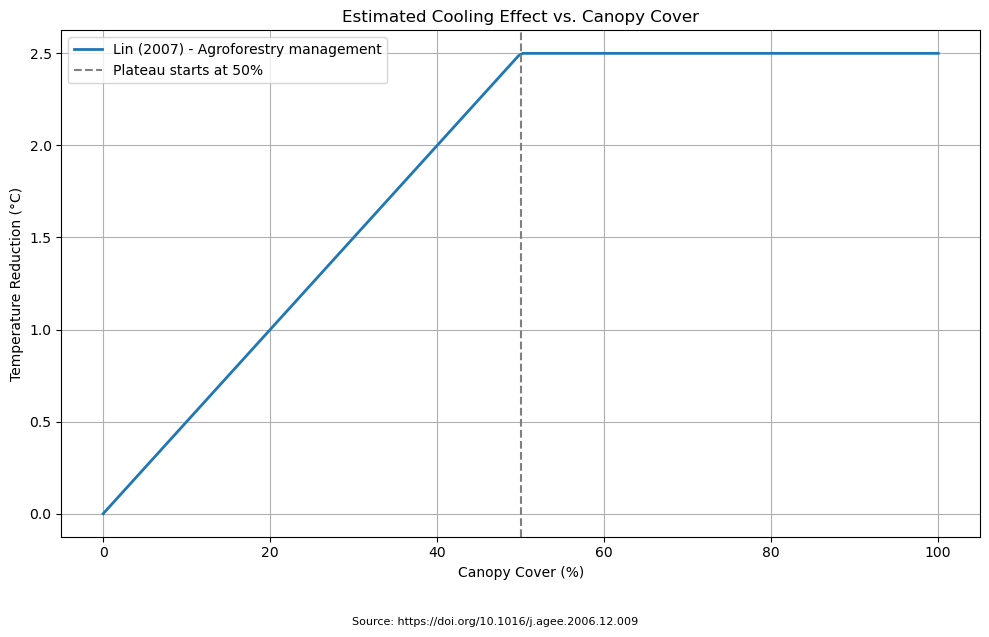

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary for scenarios
scenarios = {
    "Gomes_2020": {
        "cooling_rate_per_percent": 0.034,  # °C per 1% canopy cover
        "max_cooling": 1.7,                 # °C
        "plateau_at": 50,                   # % canopy cover
        "citation": "Gomes et al. (2020) - Agroforestry systems in Brazil",
        "link": "https://doi.org/10.1016/j.agee.2020.107090"
    },
    "Lin_2007": {
        "cooling_rate_per_percent": 0.05,    # °C per 1% canopy cover
        "max_cooling": 2.5,                  # °C
        "plateau_at": 50,
        "citation": "Lin (2007) - Agroforestry management",
        "link": "https://doi.org/10.1016/j.agee.2006.12.009"
    },
    "Niether_2018": {
        "cooling_rate_per_percent": 0.04,    # °C per 1% canopy cover (rough average)
        "max_cooling": 3.0,                  # °C
        "plateau_at": 90,
        "citation": "Niether et al. (2018) - Shade trees in cocoa systems",
        "link": "https://doi.org/10.1007/s13593-018-0540-0"
    }
}

def calculate_temperature_cooling(canopy_cover_percent, scenario_name="Gomes_2020"):
    """
    Estimate the reduction in temperature (cooling effect) based on canopy cover percentage.

    Parameters:
    - canopy_cover_percent (float): The canopy cover as a percentage (0–100%).
    - scenario_name (str): Choose between 'Gomes_2020', 'Lin_2007', 'Niether_2018'.

    Returns:
    - cooling (float): Estimated temperature reduction in °C.
    """
    scenario = scenarios[scenario_name]
    cooling_rate = scenario["cooling_rate_per_percent"]
    max_cooling = scenario["max_cooling"]
    plateau_at = scenario["plateau_at"]

    # Cap input between 0 and 100%
    canopy_cover_percent = max(0, min(canopy_cover_percent, 100))

    # Calculate cooling effect
    if canopy_cover_percent <= plateau_at:
        cooling = cooling_rate * canopy_cover_percent
    else:
        cooling = max_cooling  # Plateau after defined % cover

    return cooling

# Function to plot
def plot_cooling_curve(scenario_name="Gomes_2020"):
    # Get scenario settings
    scenario = scenarios[scenario_name]
    
    # Data
    canopy_covers = np.linspace(0, 100, 200)
    cooling_effects = [calculate_temperature_cooling(cc, scenario_name) for cc in canopy_covers]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(canopy_covers, cooling_effects, label=f'{scenario["citation"]}', linewidth=2)
    plt.axvline(x=scenario["plateau_at"], color='grey', linestyle='--', label=f'Plateau starts at {scenario["plateau_at"]}%')
    plt.title('Estimated Cooling Effect vs. Canopy Cover')
    plt.xlabel('Canopy Cover (%)')
    plt.ylabel('Temperature Reduction (°C)')
    plt.grid(True)
    plt.legend()
    plt.figtext(0.5, -0.05, f'Source: {scenario["link"]}', wrap=True, ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage
# plot_cooling_curve("Gomes_2020")  # Plot using Gomes et al. (2020) scenario
plot_cooling_curve("Lin_2007")   # You can easily switch to Lin or Niether
# plot_cooling_curve("Niether_2018")


### Step 3 - Get VPD given tree coverage

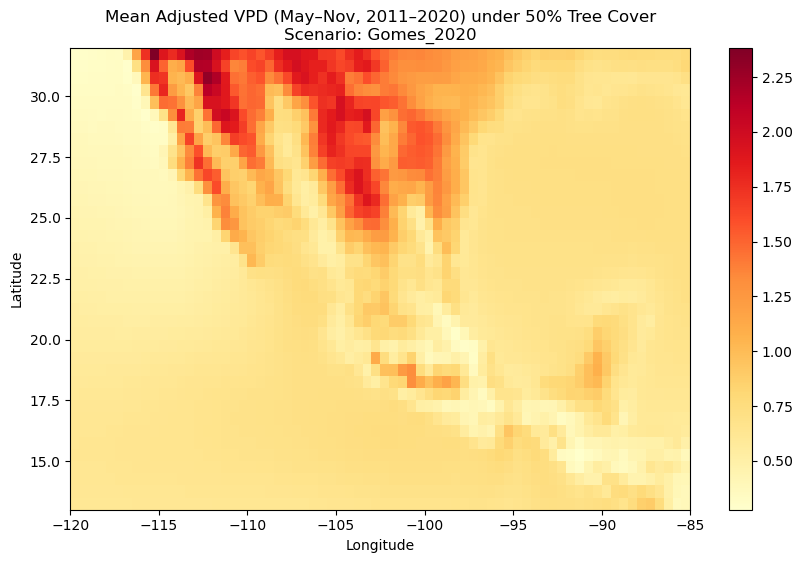

In [38]:
def calculate_vpd_adjusted(tas_celsius, hurs, canopy_cover_percent, scenario_name="Gomes_2020"):
    """
    Adjust temperature for canopy cover, then recalculate VPD.
    
    Parameters:
    - tas_celsius: xarray.DataArray (Temperature in °C)
    - hurs: xarray.DataArray (Relative humidity in %)
    - canopy_cover_percent: float or xarray.DataArray (Current canopy cover in %)
    - scenario_name: string ("Gomes_2020", "Lin_2007", "Niether_2018")

    Returns:
    - vpd_adjusted: xarray.DataArray (Adjusted VPD)
    """

    # Cooling based on tree canopy
    cooling = calculate_temperature_cooling(canopy_cover_percent, scenario_name=scenario_name)
    
    # Apply cooling to temperature
    tas_cool = tas_celsius - cooling

    # Recalculate es with cooled temperature
    es_cool = 0.6108 * np.exp((17.27 * tas_cool) / (tas_cool + 237.3))
    
    # Recalculate ea
    ea_cool = (hurs / 100) * es_cool

    # Recalculate VPD
    vpd_cool = es_cool - ea_cool

    return vpd_cool


# Example: Assume current average canopy cover is 40%
current_canopy_cover = 50  # %

# Choose the scenario
scenario_choice = "Gomes_2020"  # or "Lin_2007", "Niether_2018"

# Calculate adjusted VPD
vpd_adjusted = calculate_vpd_adjusted(
    tas_gs,
    hurs_gs,
    current_canopy_cover,
    scenario_name=scenario_choice
)

# Then continue as usual
vpd_yearly_mean_adjusted = vpd_adjusted.groupby('time.year').mean(dim='time')
vpd_growing_season_mean_adjusted = vpd_yearly_mean_adjusted.mean(dim='year')

# Plot
plt.figure(figsize=(10, 6))
vpd_growing_season_mean_adjusted.plot(cmap="YlOrRd")
plt.title(f"Mean Adjusted VPD (May–Nov, 2011–2020) under {current_canopy_cover}% Tree Cover\nScenario: {scenario_choice}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
